# Capstone Project: The Battle of Neighborhoods, Cali, Colombian version
## Data Science Professional Certificate Capstone by IBM/Coursera

### Table of contents
<ul>
    <li><a href="#Business-problem">Business problem</a></li>
    <li><a href="#Data">Data</a></li>
         <ul><li><a href="#Collection">Collection</a></li>
         <li><a href="#Preparation">Preparation</a></li></ul>
    <li><a href="#Analysis">Analysis</a></li>
    <li><a href="#Results and discussion">Results and discussion</a></li>
</ul>

## Business-problem
Cali, one of the principal cities in Colombia, and the second cheapest cities in the world to live in (According to Forbes http://bit.ly/Forbes-cali) it is also known as 'the capital of Salsa', one of the main reasons that justifies its fame. Therefore, it isn't strange the fact of having quite lots of venues throughout its streets, mainly related to dancing bars, nightclubs, discos, etc. 

<center><img src="http://dancepapi.com/wp-content/uploads/2016/02/The-Most-Famous-Salsa-Cities-in-the-World-Dance-Papi-Santiago-de-Cali.jpg" width=500 height=700 /></center>

With all these characteristics, something comes in mind: it could be a good idea to put a establishment in this city. Nevertheless, before starting getting the hands dirty we have to study the location. And... what if we want to know which is the best location in this city to put any category of venue/establishment nearby other types of venues that we want to have around? Well, data science is here for supporting us! In this project, we'll go through the path of discover the best location for a new venue having in count 3 main aspects:
<ul>
    <ul><li>The social stratum of the neighborhoods.</li>
        <li>The density or concentration of venues with similar category, measured by the frequency of that similar category in every neighborhood.</li>
        <li>How many desired venues are in that neighborhood.</li>
    </ul>    
</ul> 

## Data
Cali city is distributed in 22 <i>comunas</i> which contains different number of neighborhoods (like Boroughs in other countries, the difference is that the <i>comunas</i> instead of having names, they are enumerated, which makes the job easier for us). In total, Cali has 249 neighborhoods. Let's see where and how we can get information about Cali.

## Collection

Searching on web, we can find information about Cali comunas and neighborhoods contained in an excel file from http://planeacion.cali.gov.co . Although it is helpful, there are two problems with this dataset: firstly, it doesn't contain location data; and secondly, isn't ordered enough to analyze it. After that, we'll need to access to the venues data in all neighborhoods in Cali. So:
<ul>
    <li>We'll use <b>Geopy</b> library, in order to get the location data for each borough and neighborhood.</li>
    <li>Also, after cleaning our data, through <b>Foursquare API</b> we'll fetch the nearby venues for the boroughs and neighborhoods of our interest. </li>
</ul>    

Let's firstly import the columns in the excel file that interest us and take a look at how it looks:

In [36]:
# Install required packages 
# !conda install -c conda-forge googlemaps --yes
# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# !pip install folium

In [37]:
import pandas as pd
import numpy as np

# Data visualization
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # for ggplot-like style

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Geolocalization and maps visualization
import requests # Receive responses from requests to API's
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="Cali_explorer") # Define agent for fetch locations

import folium # Visualize maps
from folium import plugins # Added functions of folium.

# Modelling
from sklearn.preprocessing import StandardScaler # Performing feature scalling
from sklearn.cluster import KMeans # Clustering with kmeans.
from sklearn.decomposition import PCA # Dimensionality reduction.

from IPython.display import HTML

Let's download the excel file containing the dataset from the Cali Goverment website, choose the sheets, columns, and rows of interest, and rename it. 

In [38]:
data_url = 'http://planeacion.cali.gov.co/informacionestadisticacali/Barrios%20informacion/Barrios%20y%20Veredas%202016.xls'
df = pd.read_excel(data_url, 
                   sheet_name='Barrios', 
                   header=None, 
                   skiprows=8, 
                   skipfooter=7, 
                   dtype={'b':int, 'c':str})[[1,2]]
df.rename(columns={1:'Stratum', 2:'Neighborhood'}, 
          inplace=True)
print('This dataset has a size of: {}'.format(df.shape))
df.head(10)

This dataset has a size of: (378, 2)


,Stratum,Neighborhood
0,NaN,COMUNA 1
1,2,Terrón Colorado
2,1,Vista Hermosa
3,1,Sector Patio Bonito
4,1,Aguacatal
5,NaN,NaN
6,NaN,COMUNA 2
7,6,Santa Rita
8,6,Santa Teresita
9,6,Arboledas


## Preparation

As you can see above, this dataset isn't clean enough to analyze it: we'll need to drop the NaN rows, create a new column for the comunas when the nth-row is the comuna which contains the nth-neighborhood. Let's take a look at what is the first thing we found since we open the excel file and how we want to transform our data:

<div class="row">    
    <div class="column">
        <img src="Dataset Excel.PNG" style="width:50%; align:center"/>
     </div>       
</div>                              

Firstly, let's only drop the rows whose both values are null, and reset index.

In [39]:
df.drop(df[(df['Stratum'].isnull()) & df['Neighborhood'].isnull()].index, 
        inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(10)

,Stratum,Neighborhood
0,NaN,COMUNA 1
1,2,Terrón Colorado
2,1,Vista Hermosa
3,1,Sector Patio Bonito
4,1,Aguacatal
5,NaN,COMUNA 2
6,6,Santa Rita
7,6,Santa Teresita
8,6,Arboledas
9,6,Normandía


Now, let's create a new column whose rows contains the comunas corresponding to each neighborhood.

In [40]:
#Get indexes of the rows ind df which contains the different comunas.
comunas_indx = df.loc[df['Neighborhood'].isin('COMUNA ' + str(i) for i in range(1,23))].index.tolist() 

# Iterate over those indexes to fill our new 'Comuna' column. 
df['COMUNA'] = None
com_num = 1 # Start with comuna number one.
for idx in comunas_indx:
    try:
        limit = comunas_indx[com_num] # Define limit of the nth row in which the next neighborhoods belongs to the next comuna.
    except IndexError:
        limit = df.shape[0]
    df['COMUNA'][idx:limit] = int(com_num) # From idx until limit index in df Comun column, fill with the corresponding comuna for the neighborhood in the nth row.
    com_num+=1 # Next number of comuna
print('Now, our data set has size of: {}'.format(df.shape))
df.head(10) 

Now, our data set has size of: (357, 3)


,Stratum,Neighborhood,COMUNA
0,NaN,COMUNA 1,1
1,2,Terrón Colorado,1
2,1,Vista Hermosa,1
3,1,Sector Patio Bonito,1
4,1,Aguacatal,1
5,NaN,COMUNA 2,2
6,6,Santa Rita,2
7,6,Santa Teresita,2
8,6,Arboledas,2
9,6,Normandía,2


Drop the remaining "NR" (which means places that aren't urban) or null values: 

In [41]:
df.drop(df[df['Stratum'].isin(['NR']) | df['Stratum'].isnull()].index, 
        inplace=True)  # Drop rows containing 'NR' or NaN values
df.reset_index(inplace=True, drop=True)
df['Stratum'] = pd.to_numeric(df['Stratum']) 
print('Now, our data set has size of: {}'.format(df.shape))
df.head(10)

Now, our data set has size of: (328, 3)


,Stratum,Neighborhood,COMUNA
0,2,Terrón Colorado,1
1,1,Vista Hermosa,1
2,1,Sector Patio Bonito,1
3,1,Aguacatal,1
4,6,Santa Rita,2
5,6,Santa Teresita,2
6,6,Arboledas,2
7,6,Normandía,2
8,5,Juanambú,2
9,5,Centenario,2


Now that we have our dataset ordered by neighborhoods, we can merge it by the 22 comunas grouping its pertaining neighborhoods by commas separated way other column indicating the median stratum for that comuna.

In [42]:
df_merged = df.astype(str).set_index('COMUNA')
df_merged = df_merged.groupby(level='COMUNA', sort=False).agg(', '.join)
df_merged.reset_index(inplace=True, drop=False)
print('This merged dataframe has a size of: {}'.format(df_merged.shape))
df_merged.head()

This merged dataframe has a size of: (22, 3)


,COMUNA,Stratum,Neighborhood
0,1,"2, 1, 1, 1","Terrón Colorado, Vista Hermosa, Sector Patio B..."
1,2,"6, 6, 6, 6, 5, 5, 4, 5, 4, 5, 5, 5, 4, 3, 5, 6...","Santa Rita, Santa Teresita, Arboledas, Normand..."
2,3,"3, 5, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 3, 2, 3","El Nacional, El Peñón, San Antonio, San Cayeta..."
3,4,"2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2...","Jorge Isaacs, Santander, Porvenir, Las Delicia..."
4,5,"3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3","El Sena, Los Andes, Los Guayacanes, Chiminango..."


Now, let's replace the above 'Stratum' column by calculating the median stratum for each comuna and then replacing it to the df_merged dataframe.

In [43]:
mean_stratum = df.groupby('COMUNA')['Stratum'].agg(pd.Series.median).sort_index(ascending=True, axis=0).reset_index()
df_merged[['Stratum']] = mean_stratum[['Stratum']] #Replace the above column Stratum to be the median stratum of each comuna.

df_merged.columns = ['COMUNA', 'Median Stratum', 'Neighborhoods'] # Rename columns
df_merged.head()

,COMUNA,Median Stratum,Neighborhoods
0,1,1.0,"Terrón Colorado, Vista Hermosa, Sector Patio B..."
1,2,5.0,"Santa Rita, Santa Teresita, Arboledas, Normand..."
2,3,3.0,"El Nacional, El Peñón, San Antonio, San Cayeta..."
3,4,2.0,"Jorge Isaacs, Santander, Porvenir, Las Delicia..."
4,5,3.0,"El Sena, Los Andes, Los Guayacanes, Chiminango..."


Now that our dataset merged by comuna, we're ready to collect its corresponding location defining the following function:

In [44]:
def add_location_in(data_frame, by, drop_null=False):
    data_frame['Latitude'] = None
    data_frame['Longitude'] = None

    for idx in data_frame.index:
        address = str(data_frame.at[idx, by]) + ', Cali, Valle del Cauca'
        try:
            location = geolocator.geocode(str(address))
            data_frame.loc[idx,'Latitude'] = location.latitude
            data_frame.loc[idx,'Longitude'] = location.longitude
        except:
            data_frame.loc[idx, 'Latitude'] = None
            data_frame.loc[idx, 'Longitude'] = None

    number_missing = data_frame[['Latitude', 'Longitude']].isnull().sum().values[0]
    if drop_null:
        print("Couldn't found {} locations and those rows were dropped".format(number_missing))    
        data_frame.dropna(axis=0, how="any", inplace=True)
    else:
        print("Couldn't found {} locations".format(number_missing))
    
    return(pd.DataFrame(data_frame))

In [45]:
# # Get location for each comuna
# df_merged = add_location_in(df_merged, by='COMUNA')
# df_merged.head()

In [46]:
# Get location for each neighborhood
df = pd.read_csv('df.csv')
# df = add_location_in(df, by="Neighborhood")
df.head()

,Stratum,Neighborhood,COMUNA,Latitude,Longitude
0,2,Terrón Colorado,1,3.452498,-76.563183
1,1,Vista Hermosa,1,3.454899,-76.577662
2,1,Sector Patio Bonito,1,3.462149,-76.587221
3,1,Aguacatal,1,3.456254,-76.570967
4,6,Santa Rita,2,3.451469,-76.553580


In [47]:
# df = pd.read_csv('df.csv')
missing = df.iloc[np.squeeze(np.where(df['Latitude'].isna()))]
missing.head()

,Stratum,Neighborhood,COMUNA,Latitude,Longitude


In [48]:
confusing_words = ['Viejo', 'Nuevo' , 'Etapa', 'Urbanización', 'Primera', 'Segunda', 'Tercera', 'Los', 'P. 1a.', 'P. 2a.', 'P. 3a.', ' I ' , 'II', 'Pampa Linda']
replacing_words = [   ''  ,   ''    ,    ''  ,           ''  ,    '1'   ,    '2'   ,     '3'  ,   '' ,     '1' ,    '2'  ,    '3'  , ' 1'  , '2' ,  'Pampalinda']
for word, repl_word in zip(confusing_words, replacing_words):
    conf_words = missing[missing['Neighborhood'].str.contains(word, case=False)]
    missing.loc[conf_words.index, 'Neighborhood'] = missing.loc[conf_words.index, 'Neighborhood'].str.replace(word, repl_word, case=False)
missing

,Stratum,Neighborhood,COMUNA,Latitude,Longitude


In [49]:
missing = add_location_in(missing, by="Neighborhood", drop_null=True)
df.loc[missing.index] = missing
df.dropna(axis=0, how="any", inplace=True)
df.loc[missing.index]

Couldn't found 0 locations and those rows were dropped


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Stratum,Neighborhood,COMUNA,Latitude,Longitude


In [50]:
print('Finally, all {}  neighborhoods location could be fecthed'.format(df.shape[0]))
export_df = df.to_csv(r'./df.csv', index=None, header=True)

Finally, all 319  neighborhoods location could be fecthed


In [51]:
df_merged['Latitude'] = pd.read_csv('df_merged.csv')['Latitude']
df_merged['Longitude'] = pd.read_csv('df_merged.csv')['Longitude']
df_merged.head()

# if all((Latitude, Longitude != None) for i, Latitude, Longitude in df_merged[['Latitude','Longitude']].itertuples()):
#      print('All locations were fecthed')
# df_merged[df_merged[['Latitude']].values == None]

,COMUNA,Median Stratum,Neighborhoods,Latitude,Longitude
0,1,1.0,"Terrón Colorado, Vista Hermosa, Sector Patio B...",3.457820,-76.555842
1,2,5.0,"Santa Rita, Santa Teresita, Arboledas, Normand...",3.472448,-76.522936
2,3,3.0,"El Nacional, El Peñón, San Antonio, San Cayeta...",3.450514,-76.535708
3,4,2.0,"Jorge Isaacs, Santander, Porvenir, Las Delicia...",3.471036,-76.510298
4,5,3.0,"El Sena, Los Andes, Los Guayacanes, Chiminango...",3.473069,-76.495027


### Collecting venues from Foursquare API
Now, the last task in our collection stage is fetching the venues nearby each neighborhoods, we'll choose the venues around a radius distance, with a limit of venues per call.  

In [52]:
# @hidden_cell
CLIENT_ID = 'SUGFJT0UV3D3TTYPMGM4HBZIDJLLYLC13BMIHMLESOKZKAAG' # your Foursquare ID
CLIENT_SECRET = 'UZGQLI1RBC2O2FQREM3LYJRWNJTFIQFVMZLLKXILCZSHY44L' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    column_name = str(names.name)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [column_name, 
                  '{} Latitude'.format(column_name), 
                  '{} Longitude'.format(column_name), 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
# cali_venues = getNearbyVenues(names=df['Neighborhood'], 
#                                 latitudes=df['Latitude'], 
#                                 longitudes=df['Longitude'], 
#                                 radius=1000, 
#                                 LIMIT=200
#                                )
# print('{} venues were fetched by Foursquare API.'.format(cali_venues.shape[0]))
# print('{} unique venues were fetched by Foursquare API'.format(cali_venues.drop_duplicates(subset=['Venue Latitude','Venue Longitude']).shape[0]))
# print('There are {} unique venues categories.'.format(len(cali_venues['Venue Category'].unique())))

We're save the resulting venues in cali_venues dataframe in a radius of 1.6 kilometers and a limit of 600 venues per comuna.

In [55]:
cali_venues = pd.read_csv('cali_venues.csv')
cali_venues.drop_duplicates(subset=['Venue Latitude','Venue Longitude'], inplace=True)

# Add the median stratum and comuna for each venue
cali_venues['Stratum'] = None
cali_venues['COMUNA'] = None
for venue in cali_venues[['Neighborhood']].itertuples():
    cali_venues.at[venue.Index, 'Stratum'] = df[df['Neighborhood'].str.contains(venue.Neighborhood)]['Stratum'].values.astype(float)[0]
    cali_venues.at[venue.Index, 'COMUNA'] = df[df['Neighborhood'].str.contains(venue.Neighborhood)]['COMUNA'].values.astype(str)[0]

print('Now, we have {} uniques venues in our dataset.'.format(cali_venues.shape[0]))
print('Now, there are {} unique venues categories.'.format(len(cali_venues['Venue Category'].unique())))
cali_venues

Now, we have 1415 uniques venues in our dataset.
Now, there are 213 unique venues categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Stratum,COMUNA
0,Terrón Colorado,3.452498,-76.563183,Hacienda Del Bosque,3.447992,-76.560816,South American Restaurant,2,1
1,Terrón Colorado,3.452498,-76.563183,Zoológico de Cali,3.447884,-76.556862,Zoo,2,1
2,Terrón Colorado,3.452498,-76.563183,Peces - Zoológico de Cali,3.448077,-76.557541,Zoo Exhibit,2,1
3,Terrón Colorado,3.452498,-76.563183,Club Emcali,3.449028,-76.564105,Water Park,2,1
4,Vista Hermosa,3.454899,-76.577662,angic's wings km 18,3.456583,-76.581650,BBQ Joint,1,1
5,Sector Patio Bonito,3.462149,-76.587221,Industria DJARI,3.463099,-76.587590,Clothing Store,1,1
6,Aguacatal,3.456254,-76.570967,Jardín Botánico de Cali,3.450302,-76.566403,Garden,1,1
7,Santa Rita,3.451469,-76.553580,Cafe Valparaiso,3.453613,-76.549647,Deli / Bodega,6,2
8,Santa Rita,3.451469,-76.553580,Bodytech Platino - Sede Oeste,3.451899,-76.547763,Gym / Fitness Center,6,2
9,Santa Rita,3.451469,-76.553580,Super A,3.453384,-76.548186,Market,6,2


After fetching the venues, we're going to eliminate the duplicated venues and add the corresponding median stratum for each venue corresponding to the comuna in which is located in. 

In [56]:
export_cali_venues = cali_venues.to_csv(r'./cali_venues.csv', index=None, header=True)

And once we have ready our dataset of venues, we will exporting it in a csv file with the purpose of don't exceeding the number of requests per day that we can do with our Foursquare developer account by avoiding repeating the same process unnecessarily. 

## Analysis

Now that we have collected the needed data and cleaned our dataset, we are able to analyze it. In this stage, we're going to discover insights about our dataset by using maps and graphs; we will automatically select the most interesting neighborhoods and addresses for our venue category of interest. 

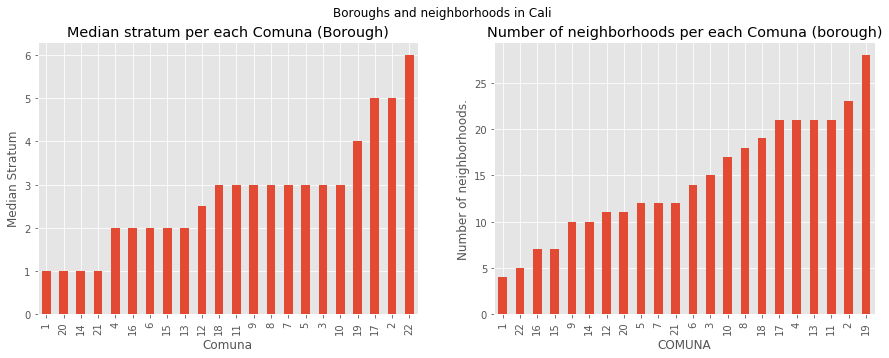

In [57]:
plt.figure(1)

plt.subplot(121)
df_merged.set_index('COMUNA')['Median Stratum'].sort_values().plot(kind='bar', figsize=(15,5))
plt.title('Median stratum per each Comuna (Borough)')
plt.xlabel('Comuna')
plt.ylabel('Median Stratum')

plt.subplot(122)
df.groupby('COMUNA').count()['Neighborhood'].sort_values().plot(kind='bar', figsize=(15,5))
plt.title('Number of neighborhoods per each Comuna (borough)')
plt.ylabel('Number of neighborhoods.')

plt.suptitle('Boroughs and neighborhoods in Cali')

plt.show()

In [58]:
# df_mgd_copy = df_merged.copy()[['COMUNA','Median Stratum']]
# df_mgd_copy['Number of Neighborhoods'] = None
# df_mgd_copy['Number of Neighborhoods'] = df.groupby('COMUNA').count()[['Neighborhood']].reset_index()
# df_mgd_copy.groupby('Number of Neighborhoods').count().reset_index()[['Median Stratum','Number of Neighborhoods']]

Let's see what are the socioeconomic level of each comuna and its number of neighborhoods.

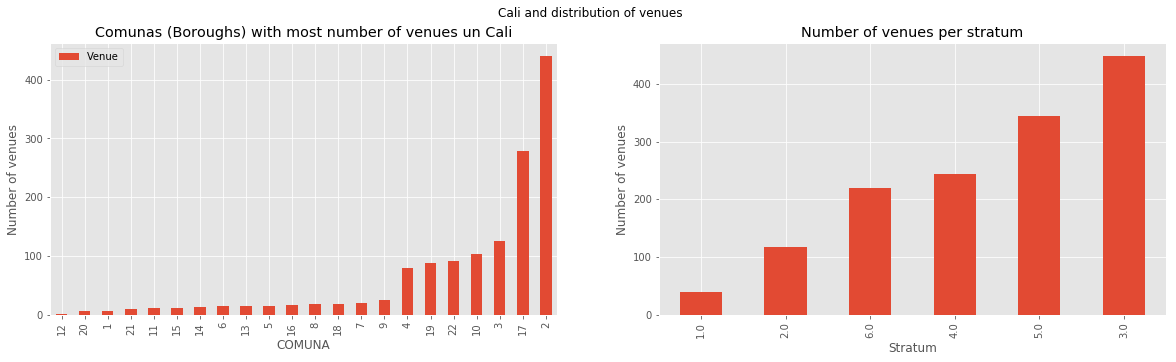

In [59]:
fig = plt.figure(figsize=(20,5))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

cali_venues.groupby('COMUNA').count()[['Venue']].sort_values(by='Venue').plot(kind='bar', ax=ax0)
ax0.set_title('Comunas (Boroughs) with most number of venues un Cali')
ax0.set_ylabel('Number of venues')

cali_venues.groupby('Stratum').count()['Venue'].sort_values().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Number of venues')
ax1.set_title('Number of venues per stratum')

plt.suptitle('Cali and distribution of venues')

plt.show()

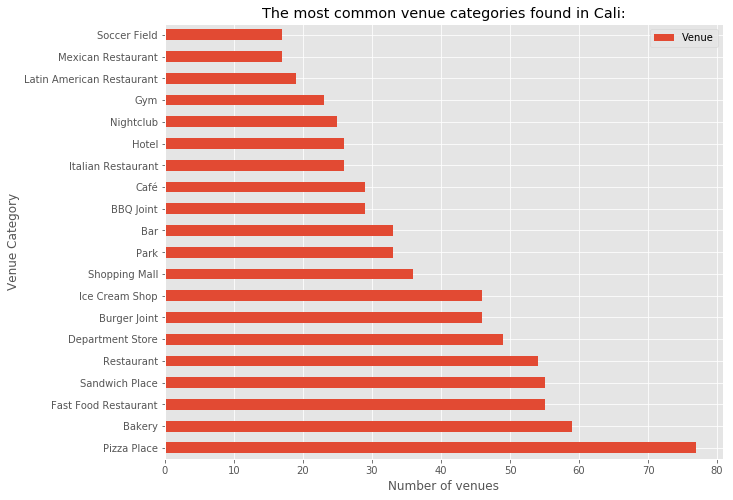

In [60]:
cali_venues.groupby('Venue Category').count().sort_values(by='Venue', ascending=False)[['Venue']].head(20).plot(kind='barh', figsize=(10,8))
plt.xlabel('Number of venues')
plt.title('The most common venue categories found in Cali:')
plt.show()

### Visualizing venues

So, now let's take a look at how are distributed the different comunas in Cali. Notice that are classified by it's social stratum; we've chosen blue colors for low, yellow for medium and red for high social stratums. Later, when we take a look at the heatmap overlapped on the cali map describing the concentration of venues along the cities, we'll found an interesting relationship between the density of venues and the social stratum of the comuna. 

Let's now define a function that returns the map of Cali with the different comunas marked and classified by its median stratum (remember that the stratum is a meassure of the socioeconomic status in that zone, the higher the stratum, the higher social status). 

In [61]:
cali_location = [3.4517923, -76.5324943]
def get_cali_map(initial_zoom, title):
    from folium.features import DivIcon

    cali_map = folium.Map(location=cali_location, zoom_start=initial_zoom)

    # add markers to map
    for lat, lng, label, stratum in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['COMUNA'], df_merged['Median Stratum']):
        popup = folium.Popup('Comuna ' + str(label) + '  Stratum: ' + str(stratum) , parse_html=True)
        if  stratum < 3: color='blue'; fill_color='blue'
        elif 3<= stratum <4: color='yellow'; fill_color='yellow'
        else:color ='orange'; fill_color='red'

        folium.CircleMarker(
            [lat, lng],
            radius=12,
            popup=popup,
            color=color,
            fill=True,
            fill_color=fill_color,
            fill_opacity=0.4,
            parse_html=False).add_to(cali_map)
        # +0.002 - 0.0029
        cali_map.add_child(folium.map.Marker([lat + 0.002, lng - 0.0029],
                     icon=DivIcon(
                     icon_size=(5,5),
                     icon_anchor=(0,0),
                     html='<div style="font-size: 11pt; color:black"; position:fixed><b>%s</b></div>' %label,
                     )))

    legend_html =   '''
                    <div style="position: fixed; 
                                bottom: 50px; left: 50px; width: 150px; height: 120px; 
                                border:2px solid grey; z-index:9999; font-size:13px;
                                ">&nbsp; Median stratum <br />
                                  &nbsp; Low &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br />
                                  &nbsp; Medium &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i><br />
                                  &nbsp;   High &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br />
                    </div>
                    ''' 
    cali_map.get_root().html.add_child(folium.Element(legend_html))
    cali_map.get_root().html.add_child(folium.Element("<h4>{}</h4>".format(title)))
    return(cali_map)

In [62]:
cali_map = get_cali_map(initial_zoom=12, title='Distibution of comunas (Boroughs) in Cali:')
cali_map

As you can see above, the distibution of medium and high social stratum in Cali is present throughout the city from the north until the southern part of the city. The east and west parts are characterized for having low social stratum. You can click on each circle mark on the above map and see the specific medium stratum for each comuna. 

Now, let's plot a heatmap corresponding to the density of venues in Cali:

In [63]:
heat_venues_map = get_cali_map(initial_zoom=13, title='Concentration of venues in Cali: ') 

heat_data = [[row['Venue Latitude'], row['Venue Longitude']] for index, row in cali_venues.iterrows()]
plugins.HeatMap(heat_data).add_to(heat_venues_map)

heat_venues_map

After observe the above map, we can realize that there is a high correlation between the social stratum of the comuna and the number of venues it has. 
Now, let's focus on a specific category of venue in which we are interested in, let's extract them in a new data frame.

## Searching venues of interest and desired nearby venues

The following code will receive two inputs that you can try to modify and see different results: they are:
<ul>
    <li><b>The venue of interest: </b> i.e. the category of venue that you would like to establish.</li>
    <li><b>The nearby desired venues:</b> which are the venues that you want to have around your venue of interest because goes with the vibes of it.</li>
</ul>
You can try with whatever venues of interest or nearby desired venues you want; the code will automatically choose those neighborhoods in which the nearby desired venues are more frequent and within this group, it will choose the neighborhoods with least frequency of the venue of interest.

In this example, we're going to focus on:
<ul>
    <li><b>Venue of interest: Bar, Nightclub</b></li>
    <li><b>Nearby desired venues:  Hotel and Coffee.</b></li>
</ul>

i.e. we want to look for the group of neighborhoods whose more often venues are museums or Hotels and within that group, we'll choose those with the least competence of Bars or Nightclubs.

In [64]:
# Search venues categories that contains the 'Bar' term

# Venue of interest:
wanted_terms = ['Nightclub', 'Bar'] # <--- YOU CAN REPLACE THESE KEYWORDS WITH THE ONES OF YOUR CATEGORY VENUE OF INTEREST 

# Nearby desired venues:
terms = ['Hotel', 'Coffee'] # <--- YOU CAN REPLACE THESE KEYWORDS WITH THE ONES THAT YOU'D LIKE TO HAVE NEARBY YOUR VENUE OF INTEREST

search_venue_df = cali_venues[cali_venues['Venue Category'].str.contains(terms[0])] 
wanted_venue_df = cali_venues[cali_venues['Venue Category'].str.contains(wanted_terms[0])]
 
if len(terms) > 1:
    for term in terms[1:]:
        new_dataframe = cali_venues[cali_venues['Venue Category'].str.contains(term)]
        search_venue_df = search_venue_df.append(new_dataframe)
        
if len(wanted_terms) > 1:
    for wanted_term in wanted_terms[1:]:
        wanted_new_dataframe = cali_venues[cali_venues['Venue Category'].str.contains(wanted_term)]
        wanted_venue_df = wanted_venue_df.append(wanted_new_dataframe)
            
search_venue_df.drop_duplicates(subset=['Venue Latitude','Venue Longitude'], inplace=True)
search_venue_df.reset_index(drop=True, inplace=True)

wanted_venue_df.drop_duplicates(subset=['Venue Latitude','Venue Longitude'], inplace=True)
wanted_venue_df.reset_index(drop=True, inplace=True)

def list2words(list, separator):
    words = str(list[0])
    for i in range(1, len(list)-1):
        words += ', ' + str(list[i])
    if len(list) > 1:
        words += ' ' + separator + ' ' + list[-1]
    return(words)

nearby_searched_ven = list2words(terms, 'and')
wanted_ven = list2words(wanted_terms, 'and') 

print("There are {} number of venues related to {}.".format(search_venue_df.shape[0], nearby_searched_ven))
display(search_venue_df.head())
print('And {} related to {} in Cali.'.format(wanted_venue_df.shape[0], wanted_ven))
display(wanted_venue_df.head())

There are 42 number of venues related to Hotel and Coffee.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Stratum,COMUNA
0,Santa Rita,3.451469,-76.553580,Hotel Hampton by Hilton Cali,3.452999,-76.546844,Hotel,6,2
1,Santa Teresita,3.450961,-76.552250,Hotel Obelisco,3.450965,-76.544122,Hotel,6,2
2,Arboledas,3.449200,-76.548762,Hotel Dann Carlton,3.450129,-76.540511,Hotel,6,2
3,Normandía,3.453770,-76.544331,"Intercontinental Cali, un Hotel Estelar",3.450088,-76.539202,Hotel,6,2
4,Normandía,3.453770,-76.544331,Movich,3.455904,-76.537058,Hotel,6,2


And 91 related to Nightclub and Bar in Cali.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Stratum,COMUNA
0,Arboledas,3.449200,-76.548762,Sagsa Bar,3.450763,-76.542167,Nightclub,6,2
1,Juanambú,3.455167,-76.538097,Kabaret,3.459031,-76.534734,Nightclub,5,2
2,Juanambú,3.455167,-76.538097,Zaperoco,3.459138,-76.531327,Nightclub,5,2
3,Centenario,3.453229,-76.536476,El Viejo Barril,3.458497,-76.532659,Nightclub,5,2
4,Granada,3.458718,-76.533389,Extasis,3.450978,-76.534482,Nightclub,4,2


Now, let's look at the heatmap that describes the density of the destribution of the type of venue of our interest; in our case, are Bars and nigthclubs.

In [65]:
heat_venues_map = folium.Map(location=cali_location, zoom_start=12)

heat_data = [[row['Venue Latitude'], row['Venue Longitude']] for index, row in wanted_venue_df.iterrows()]
plugins.HeatMap(heat_data).add_to(heat_venues_map)

heat_venues_map

As you can see above, the center zone is the most dense in matter of Bars and Nightclubs venues.

Let's see the clusters formed by the desired nearby venues present in the city, you can interact with the map by doing zoom and discover more precisely the different venues related to Hotel, Motel, Liquor, Salsa and Dance; if you hover on the clusters, the map highlight the zones in which they are distributed.

Also, note that this map is overlapped on the above heatmap of bars and nightclubs in Cali; this means that we will see how both types of venues are intersected and we'll try to choose those with least presence of Bar and nightclubs.

In [66]:
# instantiate a mark cluster object for the incidents in the dataframe
venues = plugins.MarkerCluster().add_to(heat_venues_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(search_venue_df['Venue Latitude'], search_venue_df['Venue Longitude'], search_venue_df['Venue']):
    folium.Marker(location=[lat, lng], icon=None, popup=label).add_to(venues)
    
# display map
heat_venues_map

If you zoomed into the above map, you noticed that the neighborhoods with high concentration of bars and nightclubs have also many venues related to Hotel, Motel, Liquor, Salsa and Dance. This could make our task a little bit more difficult, but also more interesting.
Now, let's see some statistics about the venues of interest and the desired nearby venues:

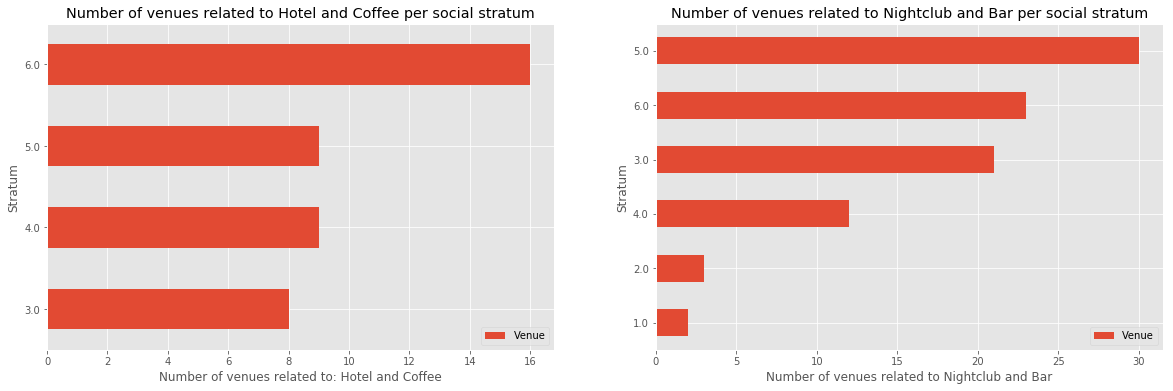

In [67]:
fig = plt.figure(figsize=(20,6))

search_venue_df.groupby('Stratum')[['Venue']].count().sort_values(by='Venue').plot(kind='barh', ax=fig.add_subplot(121))
plt.xlabel('Number of venues related to: {}'.format(nearby_searched_ven))
plt.title('Number of venues related to {} per social stratum'.format(nearby_searched_ven))

wanted_venue_df.groupby('Stratum')[['Venue']].count().sort_values(by='Venue').plot(kind='barh', ax=fig.add_subplot(122))
plt.xlabel('Number of venues related to {}'.format(wanted_ven))
plt.title('Number of venues related to {} per social stratum'.format(wanted_ven))

plt.show()

From above figure, we can conclude that the neighborhoods with lowest social stratum have least number of venues that we are focusing on.  

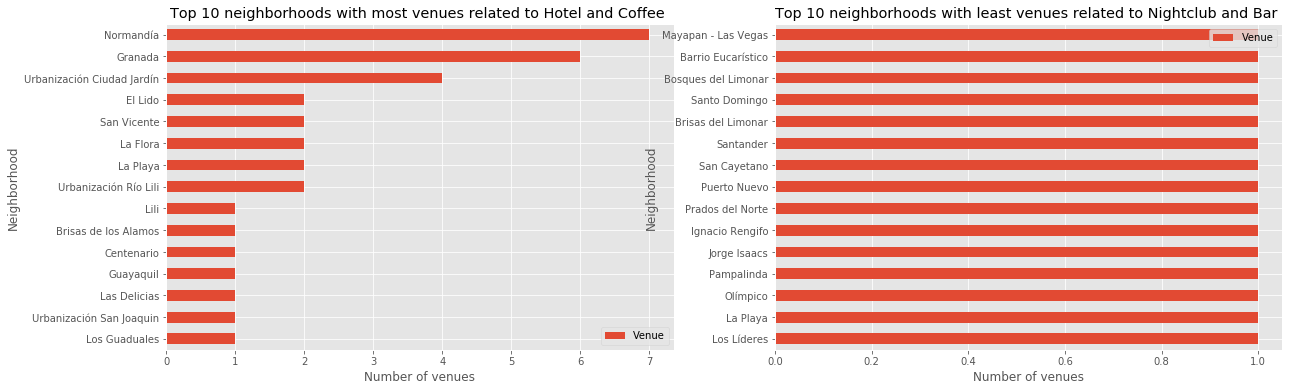

In [68]:
fig = plt.figure(figsize=(20,6))

search_venue_df.groupby('Neighborhood')[['Venue']].count().sort_values(by='Venue', ascending=True).tail(15).plot(kind='barh', ax=fig.add_subplot(121))
plt.title('Top 10 neighborhoods with most venues related to {} '.format(nearby_searched_ven))
plt.xlabel('Number of venues')

wanted_venue_df.groupby('Neighborhood')[['Venue']].count().sort_values(by='Venue', ascending=True).head(15).plot(kind='barh', ax=fig.add_subplot(122))
plt.title('Top 10 neighborhoods with least venues related to {} '.format(wanted_ven))
plt.xlabel('Number of venues')

plt.show()

Form above map, we could consider San Cayetano neighborhood a good option to have in count, because hahve two venues related to Hotels, and haven't many venues related to Bars or Nightclubs. Now, let's prepare our dataset to modeling; we're going to form a matrix of frequencies of venues categories in each neighborhood.

In [69]:
all_venues_in_neighs_tht_have_searched_venue = cali_venues.loc[cali_venues.Neighborhood.isin(search_venue_df['Neighborhood'])]

search_onehot = pd.get_dummies(all_venues_in_neighs_tht_have_searched_venue[['Venue Category']], prefix="", prefix_sep="")

search_onehot['Neighborhood'] = all_venues_in_neighs_tht_have_searched_venue['Neighborhood']

fixed_columns = [search_onehot.columns[-1]] + list(search_onehot.columns[:-1])
search_onehot = search_onehot[fixed_columns]

print('The size of this onehot encoded dataset is: {}'.format(search_onehot.shape))
freq_ven_by_neighs = search_onehot.groupby('Neighborhood').mean().reset_index()
print('New size of dataset: {}'.format(freq_ven_by_neighs.shape))
freq_ven_by_neighs.head(10)

The size of this onehot encoded dataset is: (641, 135)
New size of dataset: (23, 135)


,Neighborhood,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tennis Court,Thai Restaurant,Theater,Theme Park,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wine Bar,Wings Joint,Women's Store
0,Arboledas,0.028571,0.000000,0.000000,0.028571,0.0,0.0,0.000000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.028571,0.0,0.000000,0.000000
1,Brisas de los Alamos,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000,0.047619,0.0,0.000000,0.0,0.000000,0.000000
2,Centenario,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,...,0.0,0.000000,0.111111,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
3,El Lido,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.025,0.000000,...,0.0,0.000000,0.025000,0.025,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,Granada,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.026316,...,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.026316
5,Guayaquil,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
6,La Flora,0.019231,0.019231,0.019231,0.000000,0.0,0.0,0.000000,0.000,0.057692,...,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
7,La Playa,0.028986,0.000000,0.000000,0.000000,0.0,0.0,0.014493,0.000,0.014493,...,0.0,0.014493,0.000000,0.000,0.000000,0.0,0.014493,0.0,0.028986,0.000000
8,Las Delicias,0.000000,0.000000,0.066667,0.000000,0.0,0.0,0.000000,0.000,0.000000,...,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9,Lili,0.020833,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000,0.041667,...,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.020833,0.000000


In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now that we have our dataset of frequencies, we can see the most common venues in each neighborhood.

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = freq_ven_by_neighs['Neighborhood']

for ind in np.arange(freq_ven_by_neighs.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(freq_ven_by_neighs.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arboledas,Bar,Ice Cream Shop,Pizza Place,Sushi Restaurant,Restaurant,Park,Brewery,Burger Joint,Café,Pub
1,Brisas de los Alamos,Ice Cream Shop,Nightclub,Historic Site,Market,Pizza Place,Department Store,Coffee Shop,Diner,Restaurant,Donut Shop
2,Centenario,Hotel,Theater,Salsa Club,Bar,Steakhouse,Restaurant,Nightclub,Fast Food Restaurant,Optical Shop,Dessert Shop
3,El Lido,Sandwich Place,Shopping Mall,Department Store,Park,Burger Joint,Plaza,Recreation Center,Bowling Green,Latin American Restaurant,Fast Food Restaurant
4,Granada,Hotel,Park,Shopping Mall,Fried Chicken Joint,Sandwich Place,Pub,Women's Store,Seafood Restaurant,Café,Peruvian Restaurant
5,Guayaquil,Gym,Hotel,Dog Run,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Women's Store
6,La Flora,Pizza Place,Bar,Fast Food Restaurant,BBQ Joint,Sandwich Place,Coffee Shop,Park,Department Store,Diner,Salad Place
7,La Playa,Sandwich Place,Café,Fast Food Restaurant,Ice Cream Shop,American Restaurant,Sporting Goods Shop,Electronics Store,Latin American Restaurant,Pizza Place,Restaurant
8,Las Delicias,Fast Food Restaurant,Bakery,Sandwich Place,Coffee Shop,Fried Chicken Joint,Chinese Restaurant,Mobile Phone Shop,Ice Cream Shop,Arepa Restaurant,Department Store
9,Lili,Ice Cream Shop,Italian Restaurant,Department Store,Café,Burger Joint,Furniture / Home Store,Bar,Clothing Store,Bakery,Sandwich Place


The above dataframe will help us a lot at the time see the most recommended neighborhoods and w'll reuse it in modeling stage.

### Modeling

In this stage, we're going to group the different neighborhoods containing the desired nearby venues by its similarity. Generally the result is distributed in a big cluster and others that are more special, but also very similar.

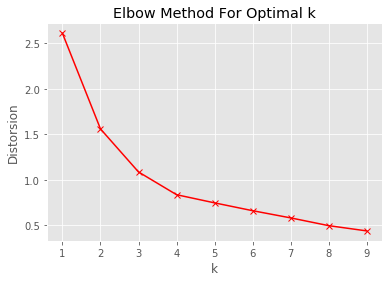

In [72]:
freq_ven_by_neighs_clustering = freq_ven_by_neighs.drop('Neighborhood', 1)

sum_sqrd_distances = []
angles_betwn_ks = []
K = range(1,10)

for i in range(len(K)) :
    kmeans = KMeans(n_clusters=K[i], random_state=0).fit(freq_ven_by_neighs_clustering)
    sum_sqrd_distances.append(kmeans.inertia_)
    
plt.plot(K, sum_sqrd_distances, 'rx-')
plt.xlabel('k')
plt.ylabel('Distorsion')
plt.title('Elbow Method For Optimal k')
plt.show()


We can choose the clusters in which we want to group our neighborhoods; however, it's a good practice to check the elbow method that tells us how many varies the noise of the clusters as we increment the number of clusters. In this case, we'll choose 3. Finally, we'll assign each cluster to it's corresponding neighborhood.

In [83]:
kmeans = KMeans(n_clusters=3).fit(freq_ven_by_neighs_clustering)
# add clustering labels
try: 
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except ValueError:
    neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1, inplace=True)
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighs_merged = df[df.Neighborhood.isin(search_venue_df['Neighborhood'].unique())]

neighs_merged = neighs_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

neighs_merged.head()

,Stratum,Neighborhood,COMUNA,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,6,Santa Rita,2,3.45147,-76.5536,2,Ice Cream Shop,Sandwich Place,Bakery,Supermarket,Hostel,Salad Place,Scenic Lookout,Deli / Bodega,Museum,Market
5,6,Santa Teresita,2,3.45096,-76.5523,2,Pizza Place,Italian Restaurant,Restaurant,Café,Sandwich Place,Peruvian Restaurant,Latin American Restaurant,Bakery,Mediterranean Restaurant,Park
6,6,Arboledas,2,3.4492,-76.5488,2,Bar,Ice Cream Shop,Pizza Place,Sushi Restaurant,Restaurant,Park,Brewery,Burger Joint,Café,Pub
7,6,Normandía,2,3.45377,-76.5443,2,Hotel,Restaurant,Italian Restaurant,Latin American Restaurant,Falafel Restaurant,Shopping Mall,French Restaurant,Sandwich Place,Burger Joint,Pharmacy
9,5,Centenario,2,3.45323,-76.5365,2,Hotel,Theater,Salsa Club,Bar,Steakhouse,Restaurant,Nightclub,Fast Food Restaurant,Optical Shop,Dessert Shop


Now, let's visuallize how our different clusters are distibuted throughout the city:

In [87]:
# create map
searched_venue_category_map = folium.Map(zoom_start=12, location=cali_location)

# set color scheme for the clusters
x = np.arange(kmeans.n_clusters)
ys = [i + x + (i*x)**2 for i in range(kmeans.n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, stratum, cluster in zip(neighs_merged['Latitude'], neighs_merged['Longitude'], neighs_merged['Neighborhood'], neighs_merged['Stratum'],neighs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '  S[' + str(stratum) + ']', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(searched_venue_category_map)
       
searched_venue_category_map

As you can see, ther eis one big cluster, and others that have much more less quantity, but are very similar. Let's see how many neighborhoods are in each cluster.

In [85]:
neighs_merged.groupby('Cluster Labels').count()[['Neighborhood']]

,Neighborhood
Cluster Labels,
0,1
1,2
2,20


Now, let's analize automatically each cluster and show some statistics about them.

,Stratum,Neighborhood,COMUNA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
82,3,Los Guaduales,6,0,Coffee Shop,Bus Station,Women's Store,Electronics Store,Food,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Donut Shop


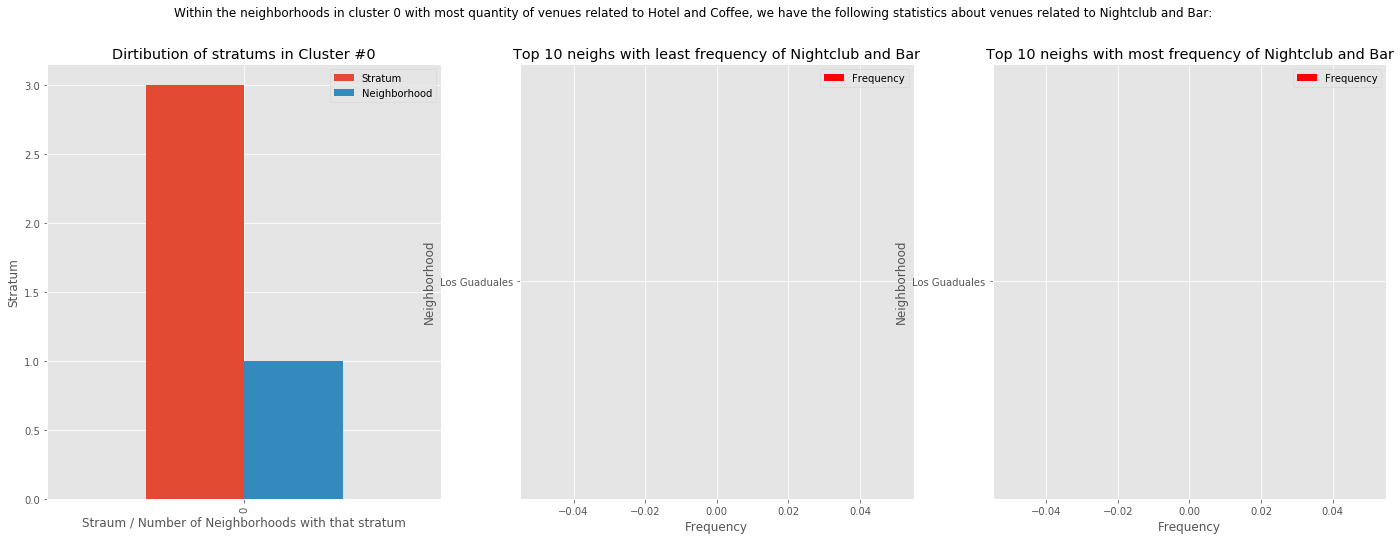

,Stratum,Neighborhood,COMUNA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
122,3,Guayaquil,9,1,Gym,Hotel,Dog Run,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Women's Store
280,5,Nueva Tequendama,19,1,Hotel,Women's Store,Donut Shop,Food,Fish & Chips Shop,Fast Food Restaurant,Falafel Restaurant,Empanada Restaurant,Electronics Store,Dog Run


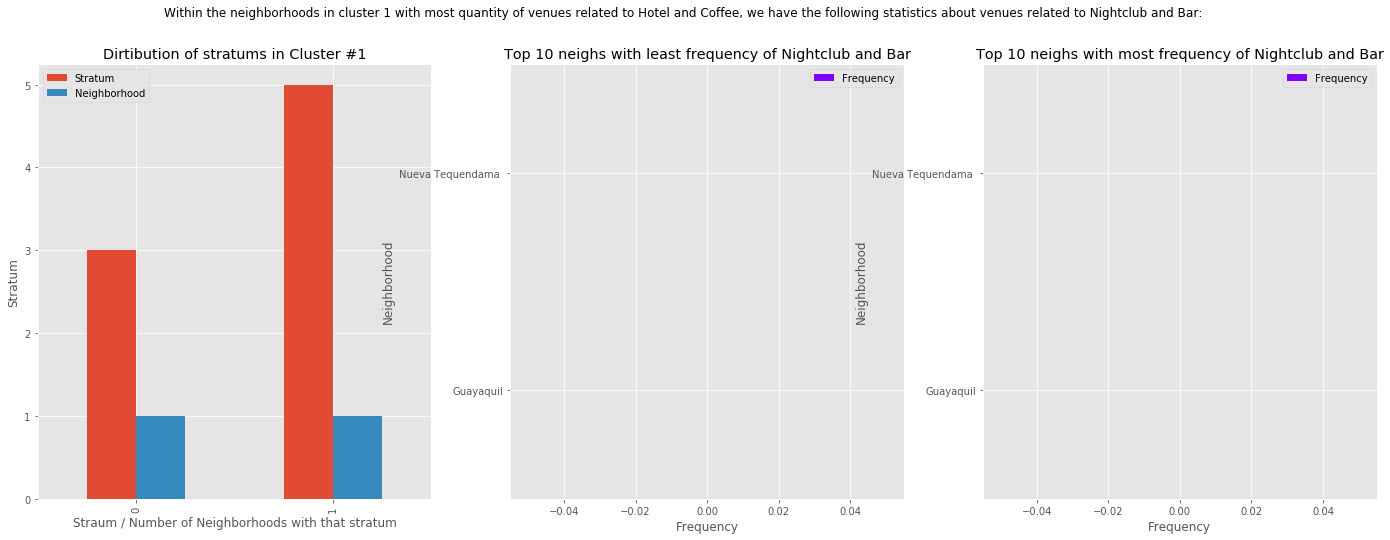

,Stratum,Neighborhood,COMUNA,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,6,Santa Rita,2,2,Ice Cream Shop,Sandwich Place,Bakery,Supermarket,Hostel,Salad Place,Scenic Lookout,Deli / Bodega,Museum,Market
5,6,Santa Teresita,2,2,Pizza Place,Italian Restaurant,Restaurant,Café,Sandwich Place,Peruvian Restaurant,Latin American Restaurant,Bakery,Mediterranean Restaurant,Park
6,6,Arboledas,2,2,Bar,Ice Cream Shop,Pizza Place,Sushi Restaurant,Restaurant,Park,Brewery,Burger Joint,Café,Pub
7,6,Normandía,2,2,Hotel,Restaurant,Italian Restaurant,Latin American Restaurant,Falafel Restaurant,Shopping Mall,French Restaurant,Sandwich Place,Burger Joint,Pharmacy
9,5,Centenario,2,2,Hotel,Theater,Salsa Club,Bar,Steakhouse,Restaurant,Nightclub,Fast Food Restaurant,Optical Shop,Dessert Shop
10,4,Granada,2,2,Hotel,Park,Shopping Mall,Fried Chicken Joint,Sandwich Place,Pub,Women's Store,Seafood Restaurant,Café,Peruvian Restaurant
12,4,San Vicente,2,2,Sandwich Place,Italian Restaurant,Bakery,Gym,Burger Joint,Café,Bed & Breakfast,Department Store,Nightclub,Asian Restaurant
13,5,Santa Mónica,2,2,Clothing Store,Gay Bar,Gym / Fitness Center,Japanese Restaurant,Arepa Restaurant,Argentinian Restaurant,Hotel,Fast Food Restaurant,BBQ Joint,Food Court
14,5,Prados del Norte,2,2,Shopping Mall,Multiplex,Soccer Field,Casino,Deli / Bodega,Big Box Store,Fried Chicken Joint,Bus Station,Bar,Burger Joint
15,5,La Flora,2,2,Pizza Place,Bar,Fast Food Restaurant,BBQ Joint,Sandwich Place,Coffee Shop,Park,Department Store,Diner,Salad Place


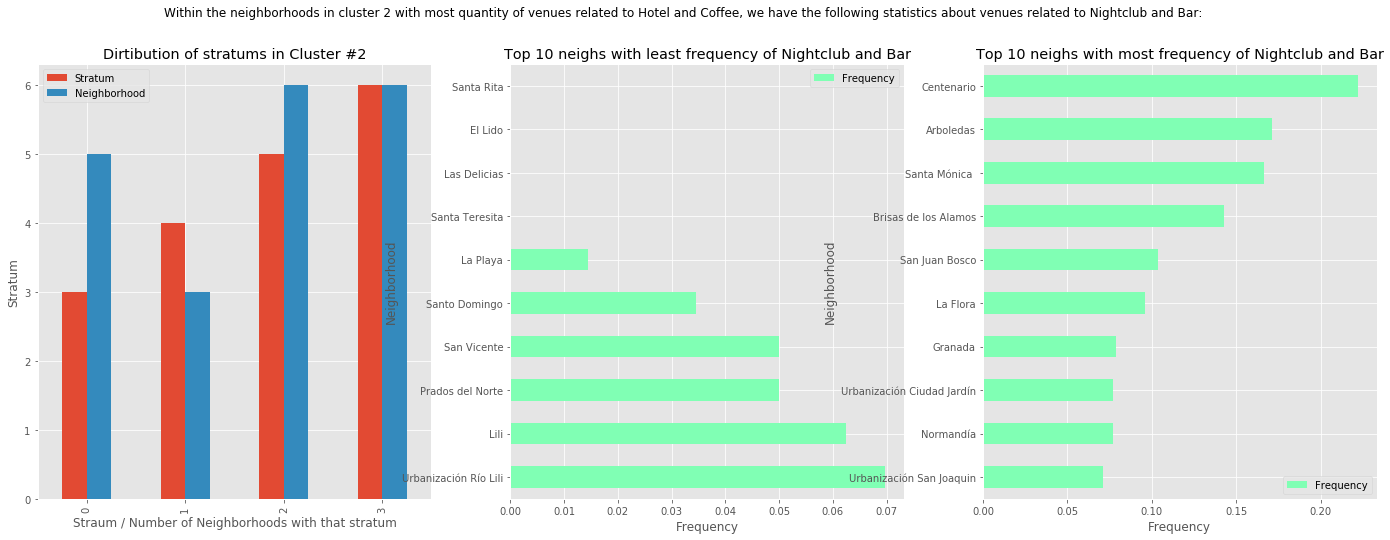

In [86]:
searched = list(wanted_venue_df[['Venue Category']].drop_duplicates().values)
freq_list = list(freq_ven_by_neighs.columns)

categories = [i[0] for i in searched if i in freq_list]
categories.append('Neighborhood')

freq = freq_ven_by_neighs.loc[:, categories]
freq['Total'] = freq.sum(axis=1)

all_clusters = neighs_merged[['Neighborhood','Stratum', 'Cluster Labels', 'Latitude', 'Longitude']].reset_index(drop=True).copy()
freq.set_index('Neighborhood', inplace=True)
all_clusters.set_index('Neighborhood', inplace=True)
all_clusters['Frequency'] = freq['Total']

def analyze_clusters(df):
    # all_clusters.sort_values(by='Frequency', ascending=True)[['Frequency']].plot(kind='barh',figsize=(10,8))
    for cluster in range(kmeans.n_clusters):
        display(HTML('<hr/><h3>CLuster {}</h3>'.format(cluster)))
        display(neighs_merged[neighs_merged['Cluster Labels'] == cluster].drop(columns=['Latitude', 'Longitude']).head(15))
        mean_stratum = df[df['Cluster Labels'] == cluster].groupby('Stratum')[['Neighborhood']].count().reset_index()
        fig = plt.figure(figsize=(24,8))
        
#       Mean stratum bar chart for each cluster        
        mean_stratum.plot(kind='bar', ax=fig.add_subplot(131))
        plt.title('Dirtibution of stratums in Cluster #{}'.format(cluster))
        plt.xlabel('Straum / Number of Neighborhoods with that stratum')
        plt.ylabel('Stratum')

        
        freq_venue_searched_per_cluster = all_clusters[all_clusters['Cluster Labels'] == cluster]
        freq_venue_searched_per_cluster.sort_values(by='Frequency', ascending=False).tail(10)\
                                          [['Frequency']].plot(kind='barh', ax=fig.add_subplot(132), color=rainbow[cluster -1])
        plt.title('Top 10 neighs with least frequency of {}'.format(wanted_ven))
        plt.xlabel('Frequency')
    
#       Fequency of venue searched in every neighborhood of this cluster
        freq_venue_searched_per_cluster = all_clusters[all_clusters['Cluster Labels'] == cluster]
        freq_venue_searched_per_cluster.sort_values(by='Frequency', ascending=True).tail(10)\
                                          [['Frequency']].plot(kind='barh', ax=fig.add_subplot(133), color=rainbow[cluster -1])
        plt.title('Top 10 neighs with most frequency of {}'.format(wanted_ven))
        plt.xlabel('Frequency')
        
        plt.suptitle('Within the neighborhoods in cluster {} with most quantity of venues related to {}, we have the following statistics about venues related to {}: '\
                     .format(cluster,nearby_searched_ven,wanted_ven))
        plt.show()    

        
        print('\n\n')
analyze_clusters(neighs_merged)

The above analysis concludes this stage, what we can extract from each cluster after this is:
<ul>
    <li><b>Cluster 0:</b> contains two neighborhoods: one with social stratum of 3, and other with 5. None of the neighborhoods in this cluster have Bar or Nightclubs.</li>
    <li><b>Cluster 1:</b> this cluster is composed of only one neighborhood of medium social stratum. There isn't bars or nightclubs yet.</li>
    <li><b>Cluster 2:</b> this cluster is the biggest, however; there are 8 neighborhoods here that haven't venues related to Bars or Nightclubs yet. Also, the social stratum of this neighborhood goes from 2 until 6.</li>
</ul>
Maybe the clusters with less number of neighborhoods could be good options to have in count as they are very different from the others. However, if we want to establish a more conventional bar, the best option would be choosing the neighborhood that matches our requirements within the cluster 2.

## Results
In this final section; we'll show the neighborhoods in each cluster with less competence within the category venue in which we are interested in, show how many nearby desired venues have and recommend concrete locations that can be considered to establish a bar or Nightclub.

In [77]:
recommended_neighs = []
display(HTML("<h3>Here are the neighborhoods recommended if you are interested in start a {} business in Cali, Colombia:</h3>".format(list2words(wanted_terms, 'or') )))
for cluster in range(kmeans.n_clusters):
    recommended_neighs.append( list(all_clusters[all_clusters['Cluster Labels'] == cluster].sort_values(by='Frequency').head().index) )
    display(HTML('<hr /><br /> <center><h4>Neighborhoods recommended in cluster {} </h4></center>'.format(cluster)))
    
    for neigh in recommended_neighs[cluster]:
        venues_in_neigh = cali_venues[cali_venues['Neighborhood'] == neigh]
        category_ven_num = venues_in_neigh.groupby('Venue Category').count().reset_index()[['Venue', 'Venue Category']]
        desired_venues_nearby = category_ven_num[category_ven_num['Venue Category'].isin(terms)]
        competence            = category_ven_num[category_ven_num['Venue Category'].isin(wanted_terms)]
        
        lat_long = venues_in_neigh[venues_in_neigh["Venue Category"].isin(terms)][['Venue Latitude', 'Venue Longitude']].values
        stratum = df[df['Neighborhood'] == neigh]['Stratum'].values[0]    
        
        display(HTML('<li>You should consider <b>{}</b> neighborhood with <b>social stratum of {}</b> because have nearby it:</li>'\
                     .format(neigh, stratum)))
        display(desired_venues_nearby.rename(columns={'Venue':'Number of venue'}) )
        display(HTML('<p>And there are: '))            
        
        if len(competence.index)>0:
            print('only these venues: ')
            display(competence[['Venue', 'Venue Category']])
        else:
            display(HTML("\t\t not {} venues yet!</p>".format(wanted_ven)))
        
        for location in lat_long: 
            display(HTML("Check this address! <a href='https://google.com/maps/?q={},{}'>google.com/maps/?q={},{}</a>".format(location[0], location[1], location[0], location[1])))
        display(HTML("<br/><br/>"))

,Number of venue,Venue Category
10,1,Hotel


,Number of venue,Venue Category
2,1,Hotel


,Number of venue,Venue Category
14,1,Hotel


,Number of venue,Venue Category


,Number of venue,Venue Category
23,1,Hotel


,Number of venue,Venue Category
1,1,Hotel


,Number of venue,Venue Category
0,1,Hotel


,Number of venue,Venue Category


Finally, the above recommendations are starter points for a more extensive study about choosing the best place to stablish a bar, but also represents smartly chosen ways to approximate to the best options. Remember that you can try with different category venues and see it's corresponding recommendations by changing the category venues keywords <a href='#Searching-venues-of-interest-and-desired-nearby-venues'>here</a>.

Thanks for read this notebook!
<br />

Atte:<br />
Sebastián García Acosta <br />
Sempiternal learner. <br />